In [ ]:
# 1. MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. SETUP PATH
import os
dataset_path = '/content/drive/MyDrive/animals'
folders = ['dogs', 'cats', 'panda']
img_size = (64, 64)
max_images = 150


In [ ]:
# 3. TRIM FOLDERS TO FIRST 100 IMAGES
for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    images = sorted(os.listdir(folder_path))
    for img in images[max_images:]:
        try: os.remove(os.path.join(folder_path, img))
        except: pass
    print(f"{folder}: {max_images} images kept.")


dogs: 150 images kept.
cats: 150 images kept.
panda: 150 images kept.


In [ ]:
# 4. LOAD IMAGES AND LABELS
import cv2
import numpy as np

features, labels = [], []

for label_idx, class_name in enumerate(folders):
    folder = os.path.join(dataset_path, class_name)
    for file in sorted(os.listdir(folder))[:max_images]:
        path = os.path.join(folder, file)
        img = cv2.imread(path)
        if img is None: continue
        img = cv2.resize(img, img_size) / 255.0
        features.append(img.flatten())
        labels.append(label_idx)

X = np.array(features)
y = np.array(labels)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Labels:", np.unique(y))


X shape: (447, 12288)
y shape: (447,)
Labels: [0 1 2]


Fold 1, k=1, Accuracy: 0.344
Fold 1, k=3, Accuracy: 0.367
Fold 1, k=5, Accuracy: 0.356
Fold 1, k=7, Accuracy: 0.356
Fold 1, k=9, Accuracy: 0.378
Fold 1, k=11, Accuracy: 0.367
Fold 1, k=13, Accuracy: 0.333
Fold 1, k=15, Accuracy: 0.333
Fold 1, k=17, Accuracy: 0.333
Fold 1, k=19, Accuracy: 0.356
Fold 1, k=21, Accuracy: 0.389
Fold 1, k=23, Accuracy: 0.367
Fold 2, k=1, Accuracy: 0.433
Fold 2, k=3, Accuracy: 0.456
Fold 2, k=5, Accuracy: 0.478
Fold 2, k=7, Accuracy: 0.489
Fold 2, k=9, Accuracy: 0.478
Fold 2, k=11, Accuracy: 0.444
Fold 2, k=13, Accuracy: 0.467
Fold 2, k=15, Accuracy: 0.422
Fold 2, k=17, Accuracy: 0.489
Fold 2, k=19, Accuracy: 0.456
Fold 2, k=21, Accuracy: 0.478
Fold 2, k=23, Accuracy: 0.500
Fold 3, k=1, Accuracy: 0.411
Fold 3, k=3, Accuracy: 0.456
Fold 3, k=5, Accuracy: 0.456
Fold 3, k=7, Accuracy: 0.456
Fold 3, k=9, Accuracy: 0.422
Fold 3, k=11, Accuracy: 0.422
Fold 3, k=13, Accuracy: 0.400
Fold 3, k=15, Accuracy: 0.389
Fold 3, k=17, Accuracy: 0.389
Fold 3, k=19, Accuracy: 0

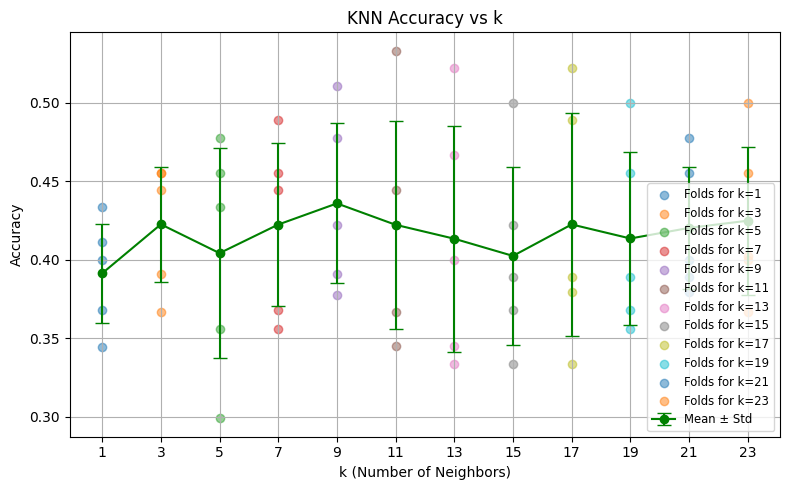

In [18]:

# (KNN,CROSS VALIDATION)

import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
np.random.seed(42)  # RANDOM SO THAT EVERY TIME IT RUNS IT GIVES THE SAME VALUE

# Euclidean distance between two feature vectors
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# KNN prediction for one test instance
def knn_predict(X_train, y_train, x_test, k):
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    distances.sort(key=lambda x: x[0])
    k_nearest_labels = [label for _, label in distances[:k]]
    most_common = Counter(k_nearest_labels).most_common(1)
    return most_common[0][0]

# STRATIFIED K-FOLDS , SO EACH FOLD GETS EQUAL NUMBER OF DOGS, CATS AND PANDAS IMAGES
def stratified_kfold(X, y, n_splits=5):
    folds_X = [[] for _ in range(n_splits)]
    folds_y = [[] for _ in range(n_splits)]

    classes = np.unique(y)
    for cls in classes:
        cls_indices = np.where(y == cls)[0]
        np.random.shuffle(cls_indices)
        split_indices = np.array_split(cls_indices, n_splits)
        for i in range(n_splits):
            folds_X[i].extend(X[split_indices[i]])
            folds_y[i].extend(y[split_indices[i]])

    for i in range(n_splits):
        folds_X[i] = np.array(folds_X[i])
        folds_y[i] = np.array(folds_y[i])

    return folds_X, folds_y

# CROSS VALIDATION
def cross_validate_knn(X, y, k_values, n_splits=5):
    folds_X, folds_y = stratified_kfold(X, y, n_splits)
    accuracies = {k: [] for k in k_values}

    for i in range(n_splits):
        X_test, y_test = folds_X[i], folds_y[i]
        X_train = np.vstack([folds_X[j] for j in range(n_splits) if j != i])
        y_train = np.hstack([folds_y[j] for j in range(n_splits) if j != i])

        for k in k_values:
            correct = 0
            for idx in range(len(X_test)):
                pred = knn_predict(X_train, y_train, X_test[idx], k)
                if pred == y_test[idx]:
                    correct += 1
            accuracy = correct / len(X_test)
            accuracies[k].append(accuracy)
            print(f'Fold {i+1}, k={k}, Accuracy: {accuracy:.3f}')

  # Printing  mean and std accuracies
    for k in k_values:
        mean_acc = np.mean(accuracies[k])
        std_acc = np.std(accuracies[k])
        print(f'k={k} -> Mean Accuracy: {mean_acc:.3f}, Std: {std_acc:.3f}')

    return accuracies

# Plotting function to show all folds, mean line, and error bars
def plot_accuracies(k_values, accuracies):
    mean_accuracies = [np.mean(accuracies[k]) for k in k_values]
    std_accuracies = [np.std(accuracies[k]) for k in k_values]

    plt.figure(figsize=(8, 5))

    for k in k_values:
        plt.scatter([k]*len(accuracies[k]), accuracies[k], alpha=0.5, label=f'Folds for k={k}')

    # Plotting mean accuracy line with error bars
    plt.errorbar(k_values, mean_accuracies, yerr=std_accuracies, fmt='-o', color='green', capsize=5, label='Mean ± Std')

    plt.title("KNN Accuracy vs k")
    plt.xlabel("k (Number of Neighbors)")
    plt.ylabel("Accuracy")
    #plt.ylim(0, 1.05)
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend(fontsize='small', loc='best')
    plt.tight_layout()
    plt.show()

k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19,21,23]

accuracies = cross_validate_knn(X, y, k_values)
plot_accuracies(k_values, accuracies)